# Improving Flu Vaccination Rates with a Targeted Outreach Program

Lovelace Health, a Federally Qualified Health Center, wishes to increase the proportion of its patients who receive the flu vaccine.  The Health Center plans to reach out to individual patients by phone to encourage them to schedule their vaccine appointments.

In addition to targeting those most at risk of complications from the flu, the health center hopes to reach out to those who are least likely to get the vaccine, in order to boost immunity in its patient population.

My task is to build a model that can use the patient health and demographic data Lovelace already has on file to predict which patients are unlikely to get the vaccine.

## Data Understanding

To build the model, I used data from the National 2009 H1N1 Flu Survey, a government-sponsored telephone survey designed to monitor vaccination rates for both flu and H1N1 during the 2009-10 season. Specifically, I used the data as curated by DrivenData for its [Flu Shot Learning](https://www.drivendata.org/competitions/66/flu-shot-learning/) competition.

For this problem, I used only data that a community health center would store in its electronic health record, although the survey results also contained information about health-related opinions and behaviors.  Additionally, although the results show whether each respondent received both the flu and H1N1 vaccines, for this exercise I focused on predicting only flu vaccine status.

The data contain over 20,000 survey responses from Americans aged 18 and over, and show that about 47% of respondents received the flu vaccine.  The data include variables showing each respondent's age, sex, race, marital status, geographic location, health insurance status, and occupation.  Additionally, the data show whether the respondent had a chronic health condition and whether their doctor recommended the flu vaccine. Several columns have a small amount of null values, and about half the data are missing in the occupation and insurance status columns.

Categories in the data are not quite representative of the U.S. population at the time.  For example, 59% of respondents were women, and the age of respondents was skewed toward older demographics.  Additionally, 


In [ ]:
X_train.

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import utils as ut

In [2]:
data = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [ ]:
# from the National 2009 H1N1 Flu Survey ReadMe:

# The National 2009 H1N1 Flu Survey (NHFS) was sponsored by the 
# National Center for Immunization and Respiratory Diseases 
# (NCIRD) and conducted jointly by NCIRD and the National 
# Center for Health Statistics (NCHS), Centers for Disease 
# Control and Prevention (CDC). The NHFS was a list-assisted 
# random-digit-dialing telephone survey of households, designed
# to monitor influenza immunization coverage in the 2009-10 season.

# The target population for the NHFS was all persons 6 months or
# older living in the United States at the time of the 
# interview. Data from the NHFS were used to produce timely estimates 
# of vaccination coverage rates for both the monovalent pH1N1 and
# trivalent seasonal influenza vaccines.

# file:///Users/lilibeit/Downloads/nhfspuf_DUG.PDF
# The NHFS was a one-time
# survey designed to monitor and evaluate the pH1N1 vaccination campaign during the 2009-10 influenza
# season. Shorter duration National Flu Surveys (NFS) followed in the 2010-11 and 2011-12 influenza seasons. 
# says the data were cleaned and checked for errors (page 18)
# The “all other races” category includes
# Asian, American Indian or Alaska Native, Native Hawaiian or Pacific Islander, and other races. If more than
# one race was selected during administration of the race questions, the respondent is classified as multi-racial.
# Because of small sample sizes and risk of disclosure within states, the NHFS public-use data file does not
# contain any variables with separate multiple-race categories. Rather, the multi-racial respondents are included
# in the “all other races” category

In [3]:
# The features in this dataset
# You are provided a dataset with 36 columns. The first column respondent_id is a unique and random identifier. The remaining 35 features are described below.

# For all binary variables: 0 = No; 1 = Yes.

# h1n1_concern - Level of concern about the H1N1 flu.
# 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
# h1n1_knowledge - Level of knowledge about H1N1 flu.
# 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
# behavioral_antiviral_meds - Has taken antiviral medications. (binary)
# behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
# behavioral_face_mask - Has bought a face mask. (binary)
# behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
# behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
# behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
# behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
# doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
# doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
# chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
# child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
# health_worker - Is a healthcare worker. (binary)
# health_insurance - Has health insurance. (binary)
# opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness.
# 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
# opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
# 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
# opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.
# 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
# opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.
# 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
# opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
# 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
# opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.
# 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
# age_group - Age group of respondent.
# education - Self-reported education level.
# race - Race of respondent.
# sex - Sex of respondent.
# income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
# marital_status - Marital status of respondent.
# rent_or_own - Housing situation of respondent.
# employment_status - Employment status of respondent.
# hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
# census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
# household_adults - Number of other adults in household, top-coded to 3.
# household_children - Number of children in household, top-coded to 3.
# employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
# employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [4]:
# train test split
# deal with nulls
# look for patterns in the nulls
# no numeric columns so no need to look for outliers
# one hot encode categorical columns
# scale
# vanilla model
# check for multicolinearity (or variables that are not independent)
# solve class imbalance problems?? - no need
# look for interactions? - marital status and sex, also employment status and sex
# logistic regression!
# -->can experiment with the regularization parameter (C)
# eval measure should be ROC-AUC (for competition anyway)
# try a tree!  a forest!
# try ensemble method?  XGBoost?
# pipeline!
# use confusion matrices to evaluate
# what can be learned from coefficients

# does health worker data match employment data?


In [5]:
# use k fold cross validation to make sure you're not overfitting to this test set
# try all combos for other models, use gridsearch
# steal and use Lindsey's evaluate function if you want - Topic 32 Pipelines plus phase 3 wrap up
# it includes a confusion matrix
# if doing a logreg, look at week 20 optional challenge

In [6]:

# look at practice notebook from week 22
# shows steps of building a simple model, testing models, iterating, choosing a model
# try to do 3 model types

# include all detail on "why did I make that decision?"  "why did I do that next step?"
# especially: why did you decide to use this model?


In [7]:
labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [8]:
# define X (predictors) and y (target)
# keep only predictors which a health management organization would have on file
# use seasonal flu vaccine outcome as target (disregard H1N1)

X = data.drop(columns=['h1n1_concern',
                       'h1n1_knowledge',
                       'behavioral_antiviral_meds',
                       'behavioral_avoidance',
                       'behavioral_face_mask',
                       'behavioral_wash_hands',
                       'behavioral_large_gatherings',
                       'behavioral_outside_home',
                       'behavioral_touch_face',
                       'doctor_recc_h1n1',
                       'child_under_6_months',
                       'opinion_h1n1_vacc_effective',
                       'opinion_h1n1_risk',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective',
                       'opinion_seas_risk',
                       'opinion_seas_sick_from_vacc',
                       'education',
                       'income_poverty',
                       'rent_or_own',
                       'household_adults',
                       'household_children'])

y = labels['seasonal_vaccine']

In [9]:
X

,respondent_id,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


In [10]:
# eliminate id column, which is the same as index number

X.drop(columns='respondent_id', inplace=True)
X

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


In [11]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [92]:
# no class imbalance in target

y_train.value_counts()
y_train.describe()

count   20030.00000
mean        0.46640
std         0.49888
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: seasonal_vaccine, dtype: float64

In [91]:
# explore variables

X_train
X_train.describe()
# X_train.info()

# many nulls
# many categorical columns --> need to encode

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6
count,18416.00000,19300.00000,19418.00000,10810.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000,20030.00000
mean,0.32944,0.28399,0.11160,0.87928,0.00539,0.09291,0.00050,0.05072,0.22841,0.12212,0.00539,0.04633,0.01118,0.05172,0.25731,0.12282
std,0.47002,0.45094,0.31488,0.32582,0.07323,0.29031,0.02234,0.21944,0.41982,0.32743,0.07323,0.21021,0.10516,0.22147,0.43716,0.32823
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


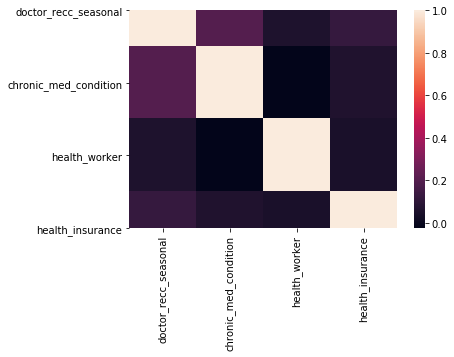

In [14]:
# heatmap shows few correlations due to high number of nulls and categorical columns

corr = X_train.corr()
sns.heatmap(corr)


In [15]:
# show per cent nulls by column
# about half of data is missing for health_insurance, employment_industry, employment_occupation

round((X_train.isna().sum()*100/len(X_train)),2)

doctor_recc_seasonal     8.06000
chronic_med_condition    3.64000
health_worker            3.06000
health_insurance        46.03000
age_group                0.00000
race                     0.00000
sex                      0.00000
marital_status           5.29000
employment_status        5.53000
hhs_geo_region           0.00000
census_msa               0.00000
employment_industry     50.00000
employment_occupation   50.52000
dtype: float64

In [16]:
# look closer at three columns with high null percentages - see if there is an obvious choice to impute

for c in X_train.columns:
    print(X_train[c].value_counts())
    
# most ppl have health insurance, I can create a new column to indicate which rows are missing this info
# employment industry and occupation - when encoded, nulls will be ignored

0.00000    12349
1.00000     6067
Name: doctor_recc_seasonal, dtype: int64
0.00000    13819
1.00000     5481
Name: chronic_med_condition, dtype: int64
0.00000    17251
1.00000     2167
Name: health_worker, dtype: int64
1.00000    9505
0.00000    1305
Name: health_insurance, dtype: int64
65+ Years        5094
55 - 64 Years    4208
45 - 54 Years    3926
18 - 34 Years    3922
35 - 44 Years    2880
Name: age_group, dtype: int64
White                15883
Black                 1623
Hispanic              1339
Other or Multiple     1185
Name: race, dtype: int64
Female    11891
Male       8139
Name: sex, dtype: int64
Married        10133
Not Married     8838
Name: marital_status, dtype: int64
Employed              10153
Not in Labor Force     7675
Unemployed             1094
Name: employment_status, dtype: int64
lzgpxyit    3208
fpwskwrf    2484
qufhixun    2326
oxchjgsf    2169
bhuqouqj    2115
kbazzjca    2113
mlyzmhmf    1709
lrircsnp    1531
atmpeygn    1520
dqpwygqj     855
Name: hhs_geo_

In [17]:
# create new df X_train_plot to contain a numeric age column for plotting

X_train_plot=X_train.copy()
X_train_plot['age_group_num'] = X_train_plot['age_group'].apply(lambda x:1 if (x == '18 - 34 Years')
                                                        else 2 if (x == '35 - 44 Years')
                                                        else 3 if (x == '45 - 54 Years')
                                                        else 4 if (x == '55 - 64 Years')
                                                        else 5)

In [18]:
# concatenate X_train_plot and y_train to create a df for plotting bar graphs

train_to_plot = pd.concat([X_train_plot, y_train], axis=1).drop(columns='age_group')
train_to_plot

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group_num,seasonal_vaccine
24692,1.00000,1.00000,1.00000,1.00000,White,Female,Not Married,Employed,fpwskwrf,"MSA, Principle City",fcxhlnwr,mxkfnird,5,1
3175,1.00000,0.00000,0.00000,1.00000,White,Female,Married,Not in Labor Force,qufhixun,"MSA, Not Principle City",NaN,NaN,4,1
12849,0.00000,0.00000,0.00000,nan,White,Female,Not Married,Employed,atmpeygn,"MSA, Not Principle City",fcxhlnwr,oijqvulv,3,1
1388,nan,0.00000,0.00000,nan,White,Female,Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,5,1
15445,0.00000,0.00000,0.00000,1.00000,White,Female,Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,1.00000,0.00000,0.00000,1.00000,White,Male,Not Married,Unemployed,mlyzmhmf,"MSA, Not Principle City",NaN,NaN,1,1
24731,0.00000,0.00000,0.00000,0.00000,White,Male,Not Married,Not in Labor Force,fpwskwrf,Non-MSA,NaN,NaN,4,0
9755,1.00000,1.00000,0.00000,1.00000,Black,Female,Not Married,Not in Labor Force,qufhixun,"MSA, Principle City",NaN,NaN,4,0
24664,1.00000,1.00000,0.00000,1.00000,White,Female,Not Married,Not in Labor Force,qufhixun,"MSA, Principle City",NaN,NaN,5,1


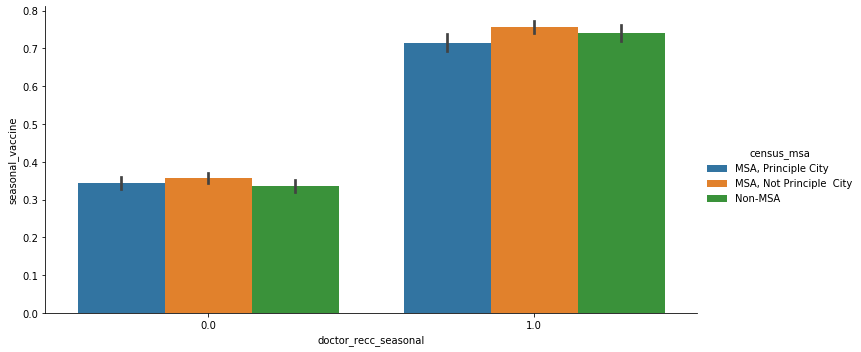

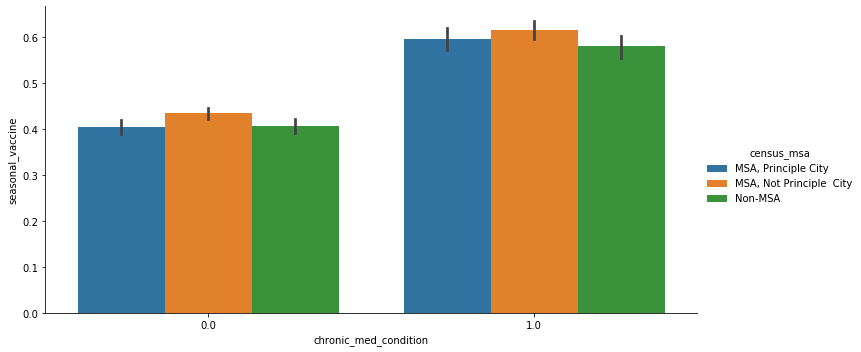

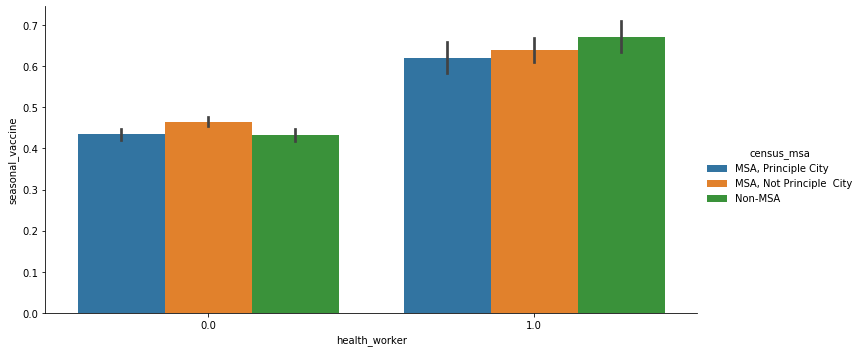

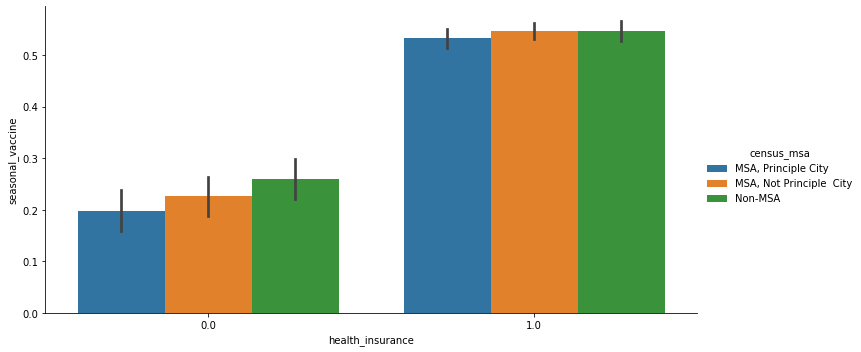

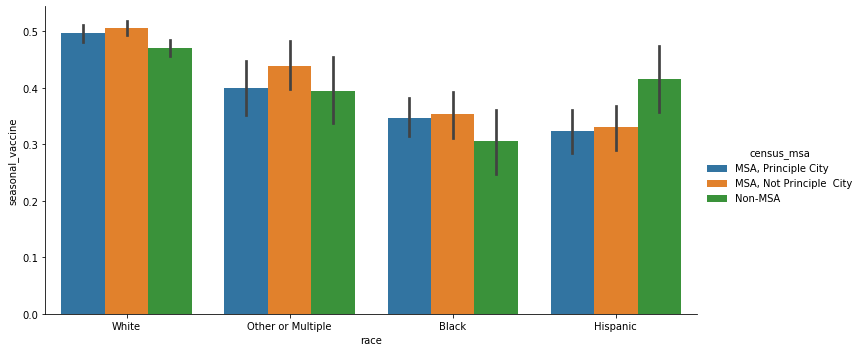

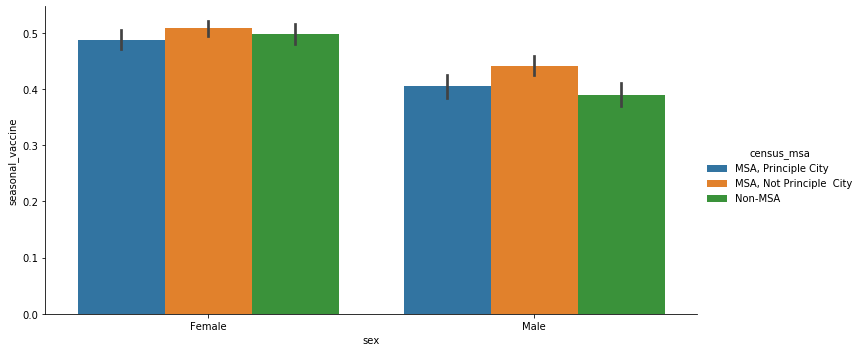

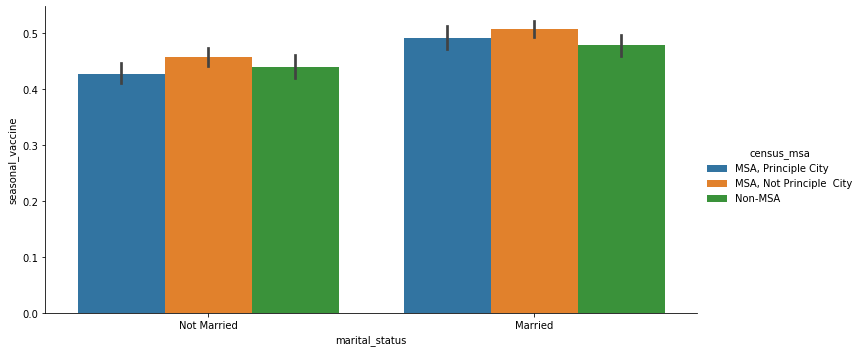

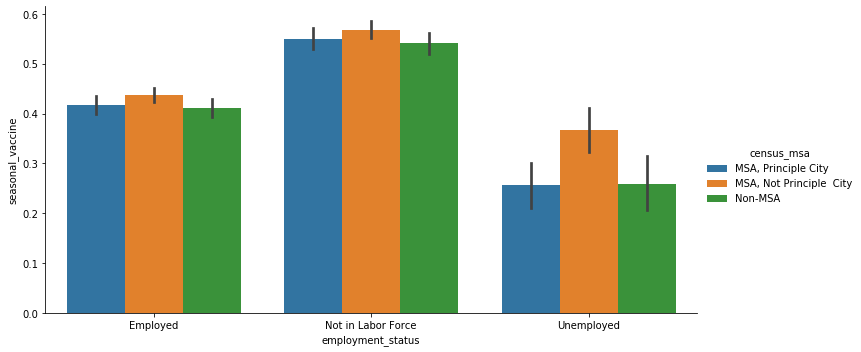

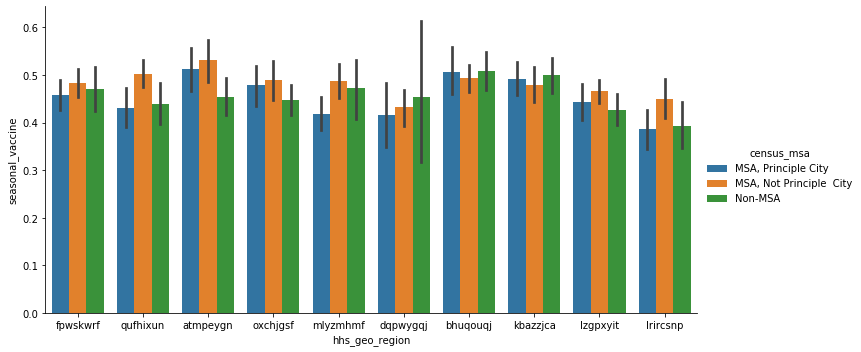

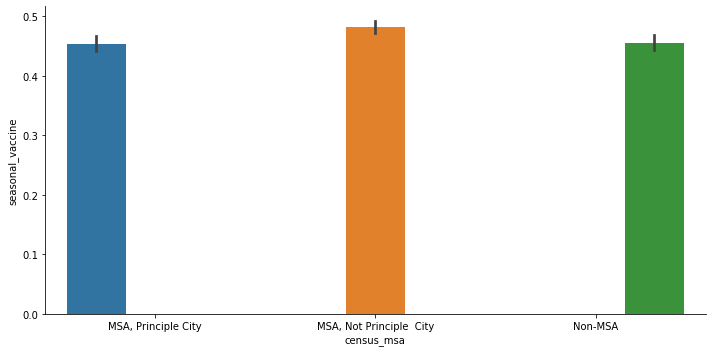

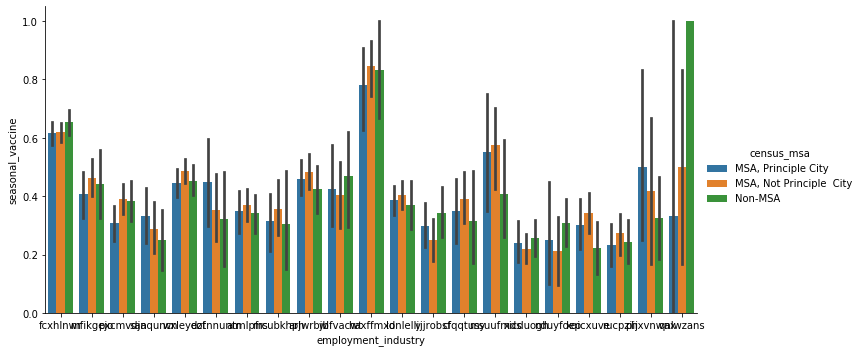

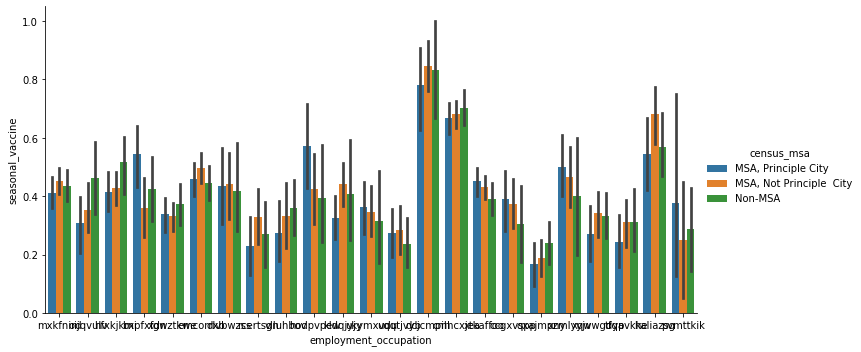

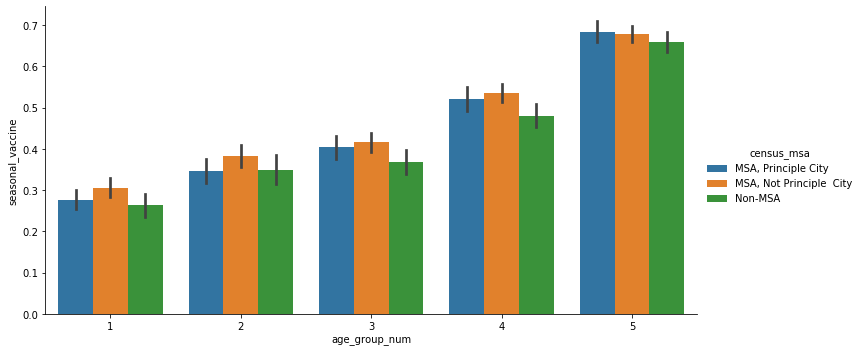

In [19]:
# plot bar graphs for each variable vs target
# test different hues to get sense of variable interactions
# interesting interactions:
# sex and marital status
# census_msa and race (what's going on?)
# sex and race
# also sex and employment status --> probably due to age

for c in train_to_plot.drop(columns=['seasonal_vaccine']).columns:
    sns.catplot(x=c, y="seasonal_vaccine", kind="bar", hue='census_msa', data=train_to_plot, height=5, aspect=2)

['haxffmxo' 'fcxhlnwr' 'msuufmds' 'qnlwzans' 'wxleyezf' 'arjwrbjb'
 'mfikgejo' 'wlfvacwt' 'ldnlellj' 'dotnnunm' 'phxvnwax' 'pxcmvdjn'
 'cfqqtusy' 'atmlpfrs' 'mcubkhph' 'xqicxuve' 'saaquncn' 'vjjrobsf'
 'nduyfdeo' 'rucpziij' 'xicduogh']


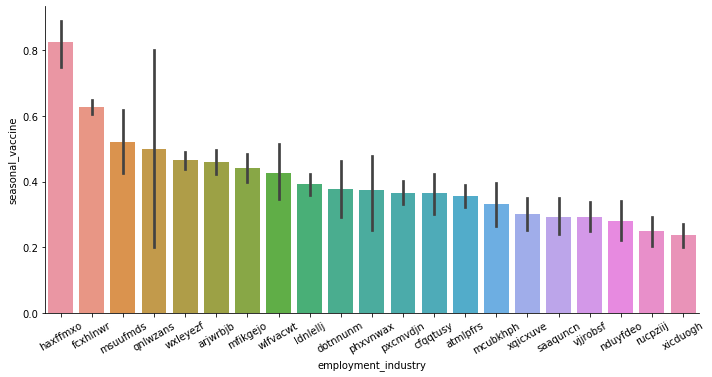

In [20]:
# arrange employment_industry values by probability - see if there are groupings
# reducing number of columns may reduce overfitting

sort_order = train_to_plot.groupby('employment_industry')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_industry', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [21]:
# create employment_industry groupings

ind_cat_1 = ['haxffmxo'] # clearly number one
ind_cat_2 = ['fcxhlnwr'] # clearly number two
ind_cat_3 = ['qnlwzans'] # clearly an oddball
ind_cat_4 = ['rucpziij','xicduogh'] # on the bottom
ind_cat_5 = ['msuufmds','arjwrbjb','wxleyezf','mfikgejo','wlfvacwt','phxvnwax','ldnlellj','dotnnunm','atmlpfrs'] # mid upper
ind_cat_6 = ['cfqqtusy','pxcmvdjn','xqicxuve','vjjrobsf','nduyfdeo','mcubkhph','saaquncn'] # mid lower

In [22]:
# create columns for employment_industry categories

ind_cat_list = [ind_cat_1, ind_cat_2, ind_cat_3, ind_cat_4, ind_cat_5, ind_cat_6]

for n, ind_cat in enumerate(ind_cat_list):
    X_train['ind_cat_'+str(n+1)] = X_train['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6
24692,1.00000,1.00000,1.00000,1.00000,65+ Years,White,Female,Not Married,Employed,fpwskwrf,"MSA, Principle City",fcxhlnwr,mxkfnird,0,1,0,0,0,0
3175,1.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Married,Not in Labor Force,qufhixun,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
12849,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Not Married,Employed,atmpeygn,"MSA, Not Principle City",fcxhlnwr,oijqvulv,0,1,0,0,0,0
1388,nan,0.00000,0.00000,nan,65+ Years,White,Female,Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
15445,0.00000,0.00000,0.00000,1.00000,65+ Years,White,Female,Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN,0,0,0,0,0,0
7876,nan,0.00000,0.00000,nan,35 - 44 Years,White,Female,Married,Employed,mlyzmhmf,"MSA, Principle City",mfikgejo,hfxkjkmi,0,0,0,0,1,0
10908,0.00000,0.00000,0.00000,1.00000,65+ Years,White,Male,Not Married,Not in Labor Force,fpwskwrf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
22365,1.00000,0.00000,1.00000,1.00000,65+ Years,White,Male,Married,Employed,atmpeygn,Non-MSA,fcxhlnwr,mxkfnird,0,1,0,0,0,0
22636,0.00000,0.00000,0.00000,nan,35 - 44 Years,Other or Multiple,Female,Married,Not in Labor Force,dqpwygqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
15939,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,atmpeygn,"MSA, Principle City",fcxhlnwr,bxpfxfdn,0,1,0,0,0,0


['dcjcmpih' 'cmhcxjea' 'haliazsg' 'xzmlyyjv' 'emcorrxb' 'hodpvpew'
 'bxpfxfdn' 'hfxkjkmi' 'mxkfnird' 'dlvbwzss' 'xtkaffoo' 'kldqjyjy'
 'ccgxvspp' 'oijqvulv' 'ukymxvdu' 'xgwztkwe' 'vlluhbov' 'xqwwgdyp'
 'tfqavkke' 'pvmttkik' 'rcertsgn' 'uqqtjvyb' 'qxajmpny']


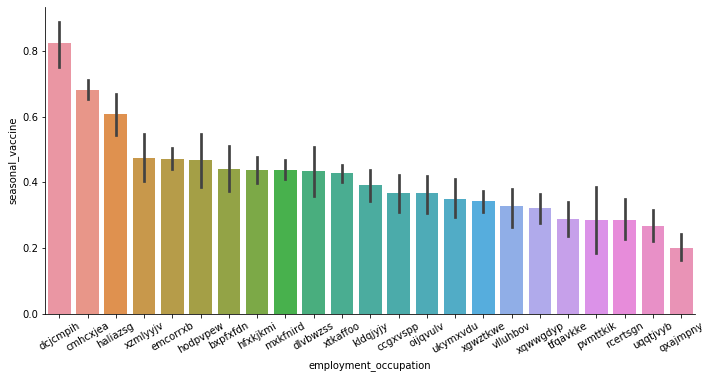

In [23]:
# arrange employment_occupation values by probability - see if there are groupings

sort_order = train_to_plot.groupby('employment_occupation')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_occupation', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [24]:
# create employment_occupation categories

occ_cat_1 = ['dcjcmpih'] # clearly number one
occ_cat_2 = ['cmhcxjea'] # clearly number two
occ_cat_3 = ['haliazsg'] # clearly number three
occ_cat_4 = ['tfqavkke','uqqtjvyb','qxajmpny'] # on the bottom
occ_cat_5 = ['xzmlyyjv', 'hodpvpew', 'emcorrxb','bxpfxfdn', 'mxkfnird', 'xtkaffoo', 'hfxkjkmi', 'dlvbwzss', 'kldqjyjy'] # mid upper
occ_cat_6 = ['vlluhbov','ukymxvdu','oijqvulv','xgwztkwe','rcertsgn','ccgxvspp','pvmttkik', 'xqwwgdyp'] # mid lower

In [25]:
# create categories for employment_occupation to reduce dimensionality

occ_cat_list = [occ_cat_1, occ_cat_2, occ_cat_3, occ_cat_4, occ_cat_5, occ_cat_6]

for n, occ_cat in enumerate(occ_cat_list):
    X_train['occ_cat_'+str(n+1)] = X_train['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6
24692,1.00000,1.00000,1.00000,1.00000,65+ Years,White,Female,Not Married,Employed,fpwskwrf,"MSA, Principle City",fcxhlnwr,mxkfnird,0,1,0,0,0,0,0,0,0,0,1,0
3175,1.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Married,Not in Labor Force,qufhixun,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
12849,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Not Married,Employed,atmpeygn,"MSA, Not Principle City",fcxhlnwr,oijqvulv,0,1,0,0,0,0,0,0,0,0,0,1
1388,nan,0.00000,0.00000,nan,65+ Years,White,Female,Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
15445,0.00000,0.00000,0.00000,1.00000,65+ Years,White,Female,Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
7876,nan,0.00000,0.00000,nan,35 - 44 Years,White,Female,Married,Employed,mlyzmhmf,"MSA, Principle City",mfikgejo,hfxkjkmi,0,0,0,0,1,0,0,0,0,0,1,0
10908,0.00000,0.00000,0.00000,1.00000,65+ Years,White,Male,Not Married,Not in Labor Force,fpwskwrf,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
22365,1.00000,0.00000,1.00000,1.00000,65+ Years,White,Male,Married,Employed,atmpeygn,Non-MSA,fcxhlnwr,mxkfnird,0,1,0,0,0,0,0,0,0,0,1,0
22636,0.00000,0.00000,0.00000,nan,35 - 44 Years,Other or Multiple,Female,Married,Not in Labor Force,dqpwygqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
15939,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,atmpeygn,"MSA, Principle City",fcxhlnwr,bxpfxfdn,0,1,0,0,0,0,0,0,0,0,1,0


In [26]:
# drop old 'employment_industry' and 'employment_occupation' columns

X_train.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
# encode remaining categorical columns in X_train
# do not drop all firsts, but drop sex_Female and race_Other to reduce columns

X_train_enc = pd.get_dummies(X_train, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# experimented with removing more firsts, but did not improve model
# scores when dropped 1 column - female
# ROC Scores
# Train: 0.7817244813917411
# Test: 0.7748843069535213

# scores when dropped 2 columns - female and other race
# ROC Scores
# Train: 0.7803958619891809
# Test: 0.7782699504901386

# scores when 5 columns dropped
# ROC Scores
# Train: 0.780485435457886
# Test: 0.772152694994743
# worse!

In [28]:
# 4 columns still have nulls
X_train_enc.isna().sum()[:4]

doctor_recc_seasonal     1614
chronic_med_condition     730
health_worker             612
health_insurance         9220
dtype: int64

In [29]:
# cannot delete rows with missing health_insurance, since about 50%
# check for overlaps in nulls in other 3 rows, may be possible to delete these rows

X_train_delete_nulls = X_train.loc[(X_train['doctor_recc_seasonal'].notnull()
                                      & X_train['chronic_med_condition'].notnull()
                                      & X_train['health_worker'].notnull())]
X_train_delete_nulls

# if we delete all nulls in all 3 columns, we lose 2295 rows, 11% of data
# so let's not delete them
# Instead, fill them with 0s and create columns to indicate if they had nulls
# also tested filling them with the dummy value 0.5, but did not improve model

print('If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:')
print('Number of rows deleted:', len(X_train) - len(X_train_delete_nulls))
print('Per cent of rows deleted:', round(((len(X_train) - len(X_train_delete_nulls))/len(X_train)*100),2), '%')


If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:
Number of rows deleted: 2244
Per cent of rows deleted: 11.2 %


In [30]:
# create new columns to capture null info prior to filling nans with 0

X_train_nans=X_train_enc.copy()
X_train_nans['null_doctor_recc'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_chronic'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_worker'] = X_train_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_ins'] = X_train_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans.head(100)

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
24692,1.00000,1.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3175,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
12849,0.00000,0.00000,0.00000,nan,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1388,nan,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1
15445,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7876,nan,0.00000,0.00000,nan,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1
10908,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
22365,1.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22636,0.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
15939,1.00000,0.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
# fill nans with 0

X_train_nans.fillna(value=0, inplace=True)
X_train_nans.isna().sum().sum() #0
X_train_nans.shape
X_train_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
24692,1.00000,1.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3175,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
12849,0.00000,0.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1388,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1
15445,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
24731,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
9755,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
24664,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


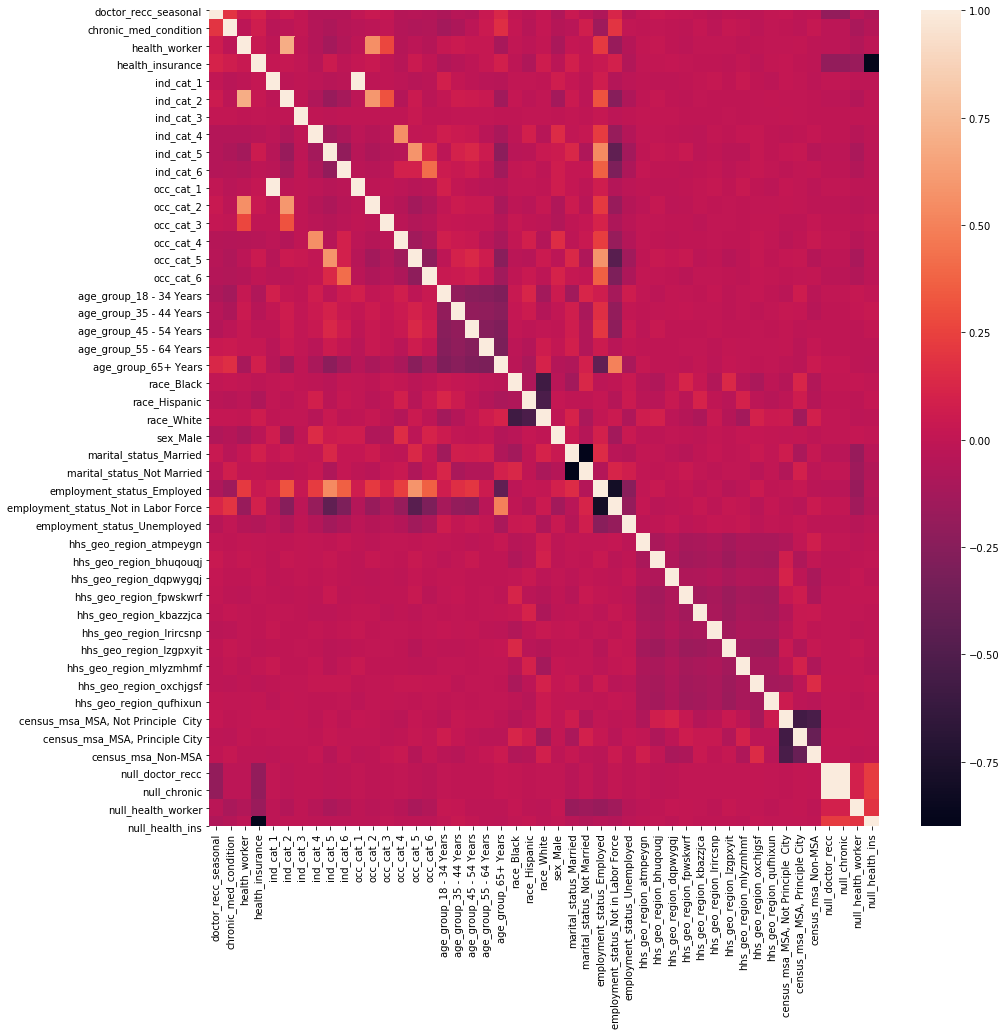

In [32]:
corr = X_train_nans.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, ax=ax);

# no surprising correlations, except maybe ind_cats and occ_cats

In [33]:
# run X_test thru same steps

# create categories for employment_industry
for n, ind_cat in enumerate(ind_cat_list):
    X_test['ind_cat_'+str(n+1)] = X_test['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)

# create categories for employment_industry
for n, occ_cat in enumerate(occ_cat_list):
    X_test['occ_cat_'+str(n+1)] = X_test['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)

X_test.drop(columns=['employment_industry','employment_occupation'], inplace=True)

# encode categorical columns
X_test_enc = pd.get_dummies(X_test, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# create columns to track null values
X_test_nans=X_test_enc.copy()
X_test_nans['null_doctor_recc'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_chronic'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_worker'] = X_test_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_ins'] = X_test_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)

# fill remaining nulls with 0
X_test_nans.fillna(value=0, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pan

In [34]:
X_test_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
4567,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
1885,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
18371,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
20125,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
59,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
22165,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
2542,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
23543,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


ROC Scores
Train: 0.7801957200723794
Test: 0.7753113759901391


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551


Cross-Validation Scores:
Train:
[0.70768847 0.71542686 0.7216675  0.70469296 0.71467798]
Test:
[0.7245509  0.68413174 0.7071161  0.717603   0.69662921]


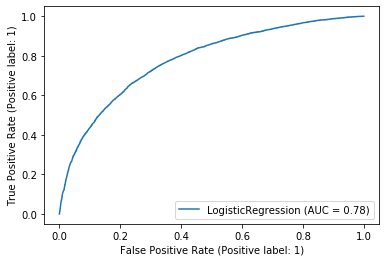

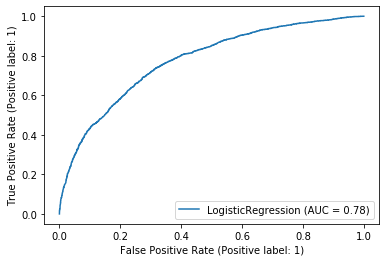

In [35]:
# plot ROC curves
logreg = ut.logreg_predict_score(X_train_nans, X_test_nans, y_train, y_test)
plot_roc_curve(logreg, X_train_nans, y_train)
plot_roc_curve(logreg, X_test_nans, y_test)


In [36]:
# Let's scale it!  # test Standard Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

In [37]:
ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7802070373543215
Test: 0.7754456076653504


Accuracy Scores
Train: 0.7121817274088866
Test: 0.7090010483750188


F1 Scores
Train: 0.6930735239312144
Test: 0.6885718865202758


Cross-Validation Scores:
Train:
[0.70144783 0.71318023 0.71517723 0.70294558 0.71517723]
Test:
[0.72230539 0.69011976 0.7071161  0.71310861 0.69662921]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [38]:
# Let's scale it!  # test MixMax Scaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7801957200723794
Test: 0.7753113759901391


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551


Cross-Validation Scores:
Train:
[0.70768847 0.71542686 0.7216675  0.70469296 0.71467798]
Test:
[0.7245509  0.68413174 0.7071161  0.717603   0.69662921]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [39]:
# add interaction term for man & married

X_train_inter = X_train_nans.copy()
X_train_inter['man_Married'] = X_train_inter['sex_Male'] * X_train_inter['marital_status_Married']
X_train_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
24692,1.00000,1.00000,1.00000,1.00000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3175,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
12849,0.00000,0.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1388,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0
15445,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
24731,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9755,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
24664,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [40]:
# do same steps on X_test
X_test_inter = X_test_nans.copy()
X_test_inter['man_Married'] = X_test_inter['sex_Male'] * X_test_inter['marital_status_Married']
X_test_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
4567,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1885,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
18371,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
20125,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
59,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1
22165,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
2542,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
23543,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [41]:
# test version with interaction term

ut.logreg_predict_score(X_train_inter, X_test_inter, y_train, y_test)

# no change

ROC Scores
Train: 0.780199966556931
Test: 0.7753017235780103


Accuracy Scores
Train: 0.7144782825761358
Test: 0.7060056911786731


F1 Scores
Train: 0.6821541710665258
Test: 0.6711341933322166


Cross-Validation Scores:
Train:
[0.70569146 0.71542686 0.71942087 0.70469296 0.71617574]
Test:
[0.7238024  0.68488024 0.70561798 0.71685393 0.69588015]


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

ROC Scores
Train: 0.7801957701488481
Test: 0.7753116466185165


Accuracy Scores
Train: 0.7144782825761358
Test: 0.7046577804403175


F1 Scores
Train: 0.6822601255625312
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


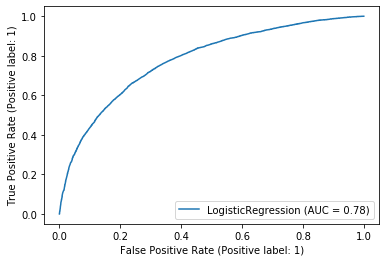

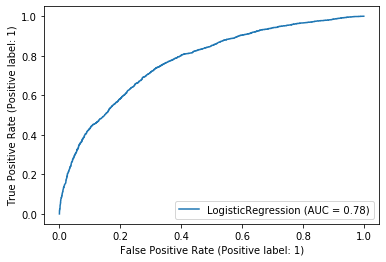

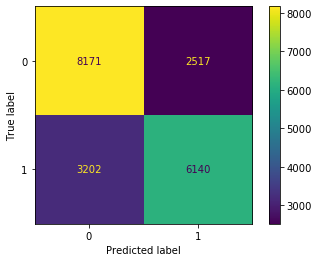

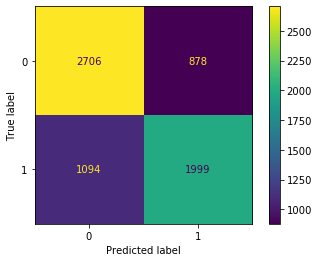

In [42]:
# test fit_intercept=True

# make logistic regression
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')
logreg.fit(X_train_nans, y_train)

# print ROC scores
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)

# no change

LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7801956399500294
Test: 0.7753073165644774


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7048075483001348


F1 Scores
Train: 0.6821869096566284
Test: 0.669904538603249
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.780194918848879
Test: 0.7753112857806799


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.780195820225317
Test: 0.7753111955712206


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Co

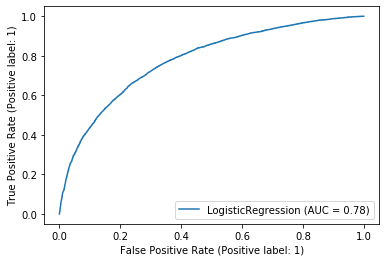

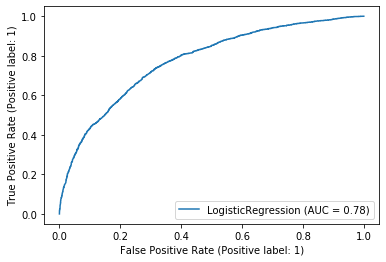

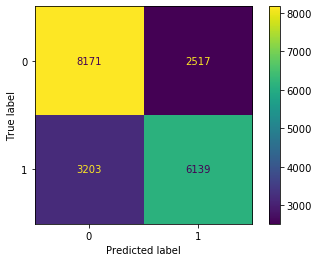

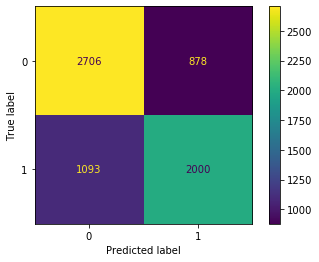

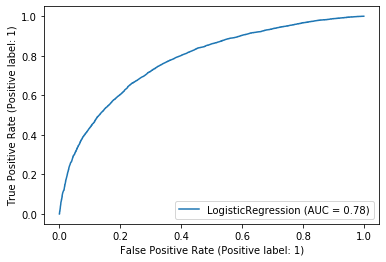

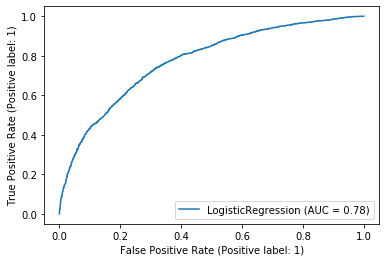

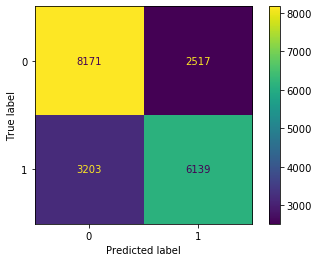

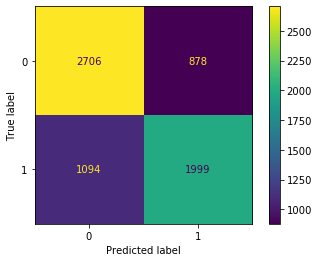

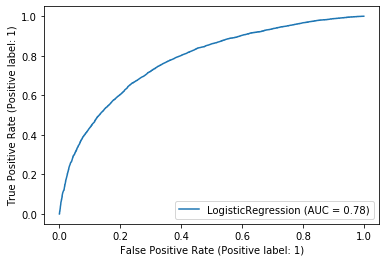

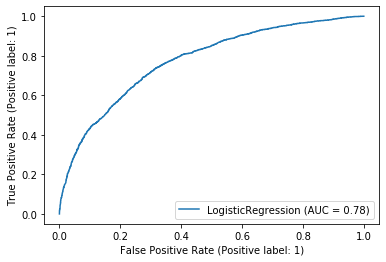

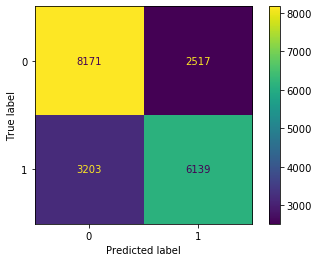

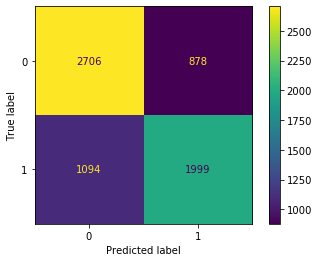

In [43]:
# test C

c_list = [10,100,1000]

# make logreg and score
for c in c_list:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    logreg.fit(X_train_nans, y_train)
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
# no change

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='newton-cg')
ROC Scores
Train: 0.7801951692312229
Test: 0.7753115564090574


Accuracy Scores
Train: 0.7144782825761358
Test: 0.7046577804403175


F1 Scores
Train: 0.6822601255625312
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:




/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegression(C=1000000000000.0, fit_intercept=False)
ROC Scores
Train: 0.7801957701488481
Test: 0.775314984368505


Accuracy Scores
Train: 0.7144782825761358
Test: 0.704957316159952


F1 Scores
Train: 0.6822601255625312
Test: 0.6700167504187604
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7801957200723794
Test: 0.7753113759901391


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='sag')
ROC Scores
Train: 0.7801952593688666
Test: 0.7753127291320262


Accuracy Scores
Train: 0.7144283574638043
Test: 0.7046577804403175


F1 Scores
Train: 0.6821869096566284
Test: 0.669681742043551
Train ROC Curve
Test ROC Curve
Train Confusion Matr

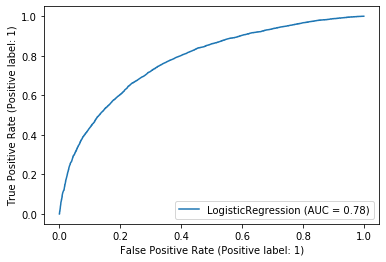

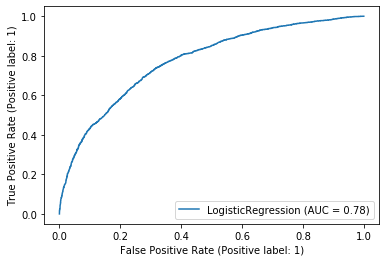

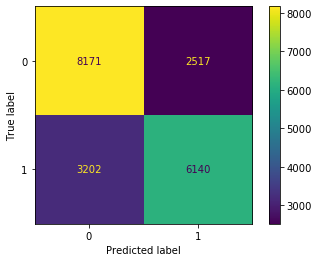

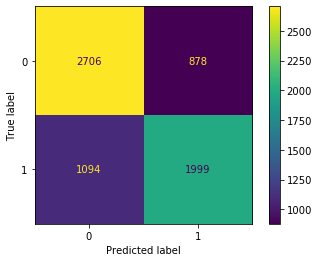

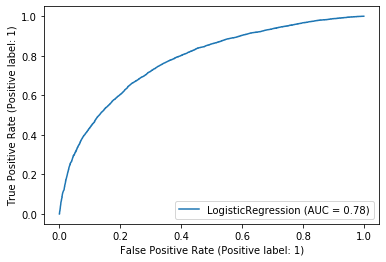

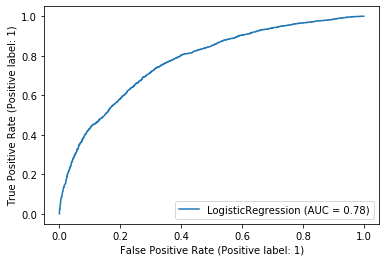

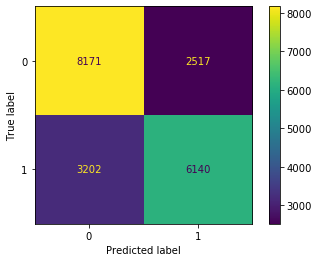

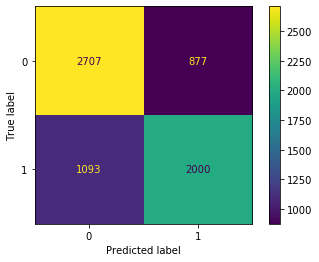

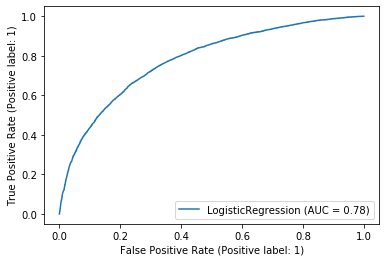

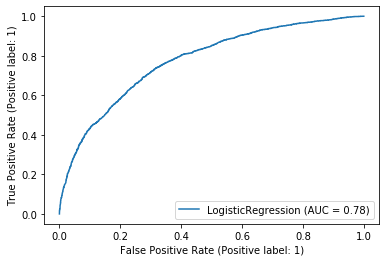

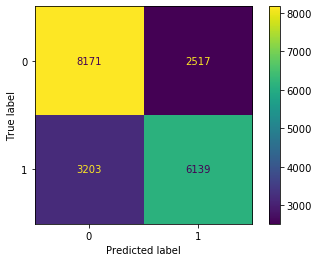

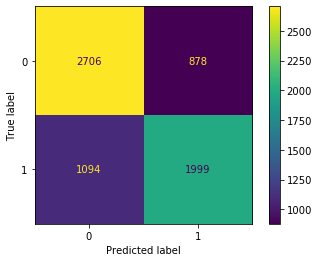

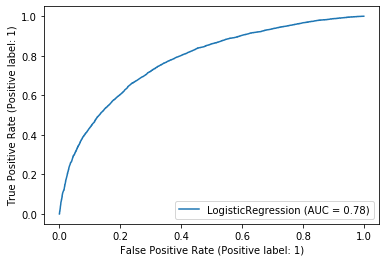

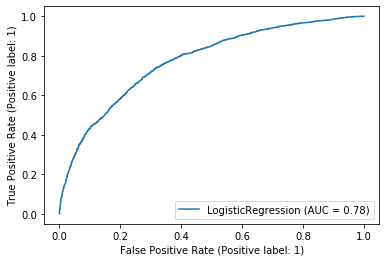

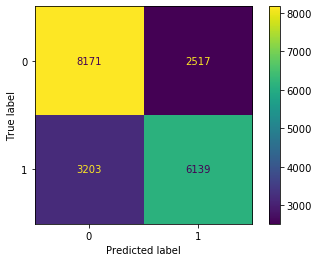

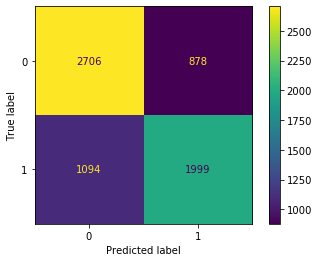

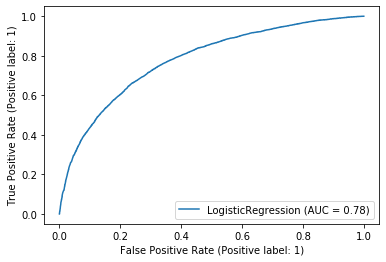

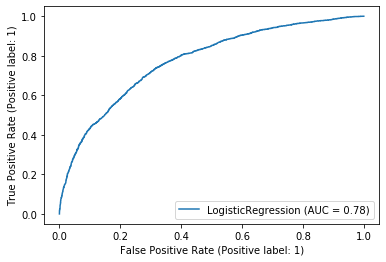

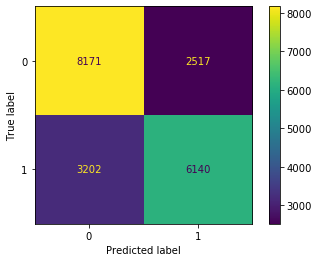

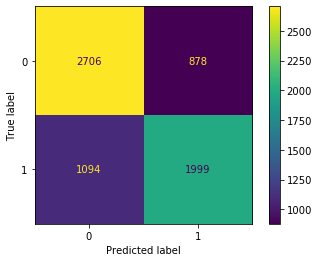

In [44]:
# test solvers

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver=s)
    logreg.fit(X_train_nans, y_train)
    # score
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
    # no change

In [45]:
# no change when using different scalers, adding interaction terms, or changing logreg parameters
# stick with inital df (X_train_nans)
# stick with initial parameters for logreg

best_logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
best_logreg.fit(X_train_nans, y_train)

# cross-validate best_logreg model

print(cross_val_score(best_logreg, X_train_nans, y_train))
print(cross_val_score(best_logreg, X_test_nans, y_test))

[0.70768847 0.71542686 0.7216675  0.70469296 0.71467798]
[0.7245509  0.68413174 0.7071161  0.717603   0.69662921]


In [90]:
# check out coefficients

order_features(best_logreg.coef_[0], X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,1.51800,1.51800
ind_cat_1,1.37730,1.37730
occ_cat_1,1.37730,1.37730
age_group_18 - 34 Years,-0.95530,0.95530
census_msa_Non-MSA,-0.69310,0.69310
age_group_35 - 44 Years,-0.69270,0.69270
health_insurance,0.65970,0.65970
health_worker,0.63120,0.63120
race_Black,-0.53880,0.53880
age_group_65+ Years,0.53840,0.53840


In [47]:
# run lists below to be sure my coefficients are linking up to the right column labels
# they are

tuple_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, best_logreg.coef_[0][n])
    tuple_list.append(tuple)
    
tuple_list

[(0, 1.5180311754437956),
 (1, 0.35323292609083173),
 (2, 0.6311740889634857),
 (3, 0.6597366732009331),
 (4, 1.3772869854499494),
 (5, 0.4974675571526851),
 (6, -0.01468166267051299),
 (7, -0.0910103128130925),
 (8, 0.3311824872287185),
 (9, 0.014624143343378025),
 (10, 1.3772869854499494),
 (11, 0.3172679512846424),
 (12, 0.19182206211029587),
 (13, -0.28246938270530814),
 (14, 0.04410813201674453),
 (15, -0.20021884868117745),
 (16, -0.9553327443464662),
 (17, -0.6926927041499209),
 (18, -0.5049155854932649),
 (19, -0.13700855612574878),
 (20, 0.5383768974635132),
 (21, -0.53877897739977),
 (22, -0.0641448401788177),
 (23, 0.10605780909407513),
 (24, -0.12088822174875657),
 (25, 0.07858361340129512),
 (26, -0.0853359974177516),
 (27, -0.4207100325549868),
 (28, -0.21907471799125294),
 (29, -0.4644881422854306),
 (30, -0.058533956775789965),
 (31, -0.14157146339941432),
 (32, -0.4176982831500805),
 (33, -0.08584207545036589),
 (34, -0.02680971500036477),
 (35, -0.3303274138205243),
 

In [48]:
col_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, X_train_nans.columns[n])
    col_list.append(tuple)
    
col_list

[(0, 'doctor_recc_seasonal'),
 (1, 'chronic_med_condition'),
 (2, 'health_worker'),
 (3, 'health_insurance'),
 (4, 'ind_cat_1'),
 (5, 'ind_cat_2'),
 (6, 'ind_cat_3'),
 (7, 'ind_cat_4'),
 (8, 'ind_cat_5'),
 (9, 'ind_cat_6'),
 (10, 'occ_cat_1'),
 (11, 'occ_cat_2'),
 (12, 'occ_cat_3'),
 (13, 'occ_cat_4'),
 (14, 'occ_cat_5'),
 (15, 'occ_cat_6'),
 (16, 'age_group_18 - 34 Years'),
 (17, 'age_group_35 - 44 Years'),
 (18, 'age_group_45 - 54 Years'),
 (19, 'age_group_55 - 64 Years'),
 (20, 'age_group_65+ Years'),
 (21, 'race_Black'),
 (22, 'race_Hispanic'),
 (23, 'race_White'),
 (24, 'sex_Male'),
 (25, 'marital_status_Married'),
 (26, 'marital_status_Not Married'),
 (27, 'employment_status_Employed'),
 (28, 'employment_status_Not in Labor Force'),
 (29, 'employment_status_Unemployed'),
 (30, 'hhs_geo_region_atmpeygn'),
 (31, 'hhs_geo_region_bhuqouqj'),
 (32, 'hhs_geo_region_dqpwygqj'),
 (33, 'hhs_geo_region_fpwskwrf'),
 (34, 'hhs_geo_region_kbazzjca'),
 (35, 'hhs_geo_region_lrircsnp'),
 (36, 'h

In [88]:
# run permutation importance to confirm feature importance

r = permutation_importance(best_logreg, X_test_nans, y_test, n_repeats=30)

In [89]:
order_features(r['importances'][:,0], X_train_nans)


,weight,abs_weight
doctor_recc_seasonal,0.08340,0.08340
age_group_18 - 34 Years,0.01360,0.01360
health_insurance,0.01290,0.01290
age_group_65+ Years,0.01180,0.01180
census_msa_Non-MSA,0.01060,0.01060
age_group_35 - 44 Years,0.00870,0.00870
age_group_45 - 54 Years,0.00780,0.00780
health_worker,0.00700,0.00700
"census_msa_MSA, Not Principle City",0.00700,0.00700
employment_status_Employed,0.00670,0.00670


ROC Scores
Train: 0.9829337691828931
Test: 0.6389542757118608


Accuracy Scores
Train: 0.9131802296555167
Test: 0.626628725475513


F1 Scores
Train: 0.9035870710206798
Test: 0.5862240663900414
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


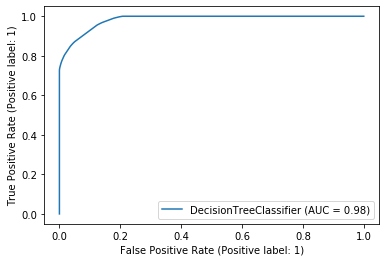

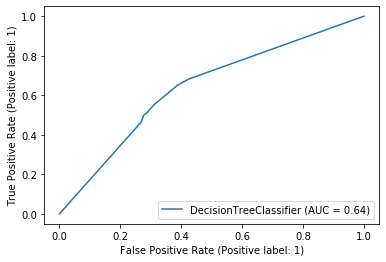

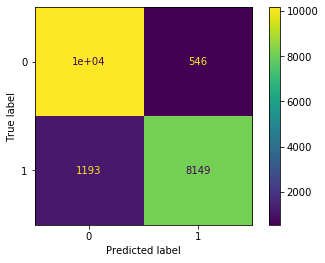

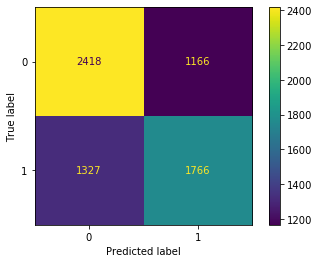

In [50]:
# let's do another model!

tree = DecisionTreeClassifier()

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# yikes, that's really overfit!  let's prune the tree

ROC Scores
Train: 0.7708170434580423
Test: 0.7619487390160963


Accuracy Scores
Train: 0.7140788816774838
Test: 0.7016624232439719


F1 Scores
Train: 0.688156820038116
Test: 0.6746161385168246
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


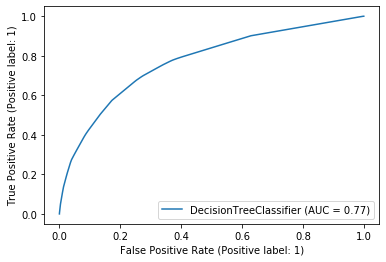

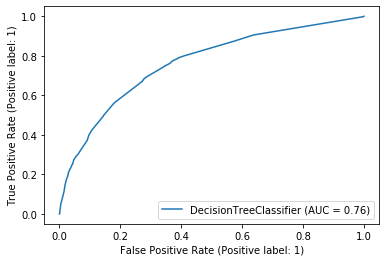

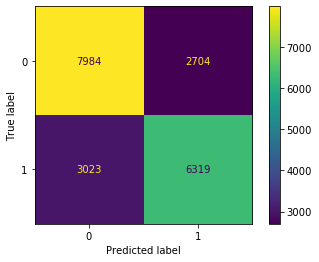

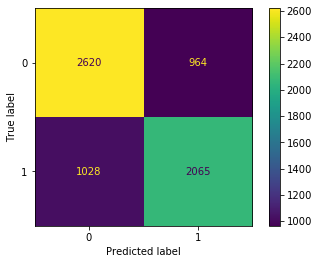

In [51]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, max_features=40, criterion='gini')

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# better, but not better than logreg

In [53]:
tree.feature_importances_

array([4.88175283e-01, 1.67356730e-02, 7.33083115e-02, 2.00486381e-02,
       1.88098618e-02, 9.49512943e-03, 0.00000000e+00, 0.00000000e+00,
       1.46543679e-02, 4.19609329e-03, 0.00000000e+00, 7.85712890e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.63350170e-03,
       7.17835442e-03, 0.00000000e+00, 0.00000000e+00, 3.95425377e-02,
       2.58221965e-01, 1.06312848e-02, 9.89490048e-04, 8.37387889e-03,
       0.00000000e+00, 1.53541479e-03, 2.37319439e-03, 0.00000000e+00,
       6.66487844e-04, 7.73463038e-04, 0.00000000e+00, 3.93177211e-04,
       3.04029982e-03, 3.74712027e-04, 0.00000000e+00, 2.00795058e-03,
       2.01292358e-03, 2.91014944e-03, 0.00000000e+00, 8.47533198e-04,
       1.21344054e-03, 0.00000000e+00, 8.47823222e-04, 0.00000000e+00,
       0.00000000e+00, 7.61119983e-04, 3.90810766e-04])

In [54]:
order_features(tree.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.48820,0.48820
age_group_65+ Years,0.25820,0.25820
health_worker,0.07330,0.07330
age_group_55 - 64 Years,0.03950,0.03950
health_insurance,0.02000,0.02000
ind_cat_1,0.01880,0.01880
chronic_med_condition,0.01670,0.01670
ind_cat_5,0.01470,0.01470
race_Black,0.01060,0.01060
ind_cat_2,0.00950,0.00950


In [55]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [30, 37, 45]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)
tree_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {tree_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {tree_grid_search.best_params_}")

Training Accuracy: 70.73%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 37, 'min_samples_leaf': 14, 'min_samples_split': 12}


ROC Scores
Train: 0.7715370529413236
Test: 0.7607610863816913


Accuracy Scores
Train: 0.7109835247129306
Test: 0.7010633518047027


F1 Scores
Train: 0.6874696323489716
Test: 0.6766040181464679
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


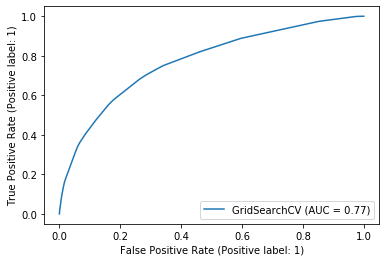

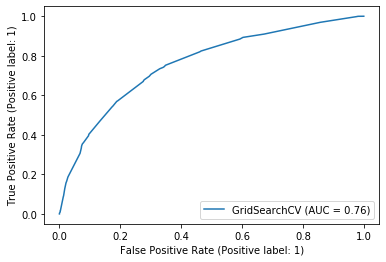

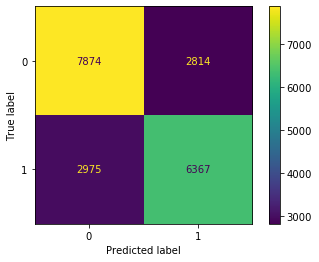

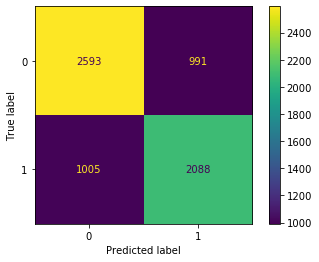

In [56]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree_grid_search)

In [57]:
tree_grid_search.best_estimator_.feature_importances_

array([5.78601919e-01, 9.23616181e-03, 7.49625066e-02, 1.76159402e-02,
       2.32152195e-02, 1.11020590e-02, 0.00000000e+00, 2.14054335e-03,
       0.00000000e+00, 4.69080037e-03, 0.00000000e+00, 2.55911945e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.37192766e-04,
       8.27105654e-02, 0.00000000e+00, 0.00000000e+00, 1.81360977e-02,
       1.34465487e-01, 1.15558395e-02, 3.83187458e-04, 9.67680049e-03,
       4.67870073e-04, 9.67919324e-04, 2.24358131e-03, 1.52687255e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.33990636e-04, 0.00000000e+00, 0.00000000e+00, 1.61521496e-03,
       2.83885113e-04, 6.72643964e-04, 0.00000000e+00, 0.00000000e+00,
       2.24117327e-05, 0.00000000e+00, 8.62891483e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.91327897e-03])

In [58]:
order_features(tree_grid_search.best_estimator_.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.57860,0.57860
age_group_65+ Years,0.13450,0.13450
age_group_18 - 34 Years,0.08270,0.08270
health_worker,0.07500,0.07500
ind_cat_1,0.02320,0.02320
age_group_55 - 64 Years,0.01810,0.01810
health_insurance,0.01760,0.01760
race_Black,0.01160,0.01160
ind_cat_2,0.01110,0.01110
race_White,0.00970,0.00970


In [59]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
bagged_tree.fit(X_train_nans, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

ROC Scores
Train: 0.7754705946168038
Test: 0.7681086017245162


Accuracy Scores
Train: 0.7129306040938592
Test: 0.7064549947581249


F1 Scores
Train: 0.6946037816018695
Test: 0.688295165394402
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


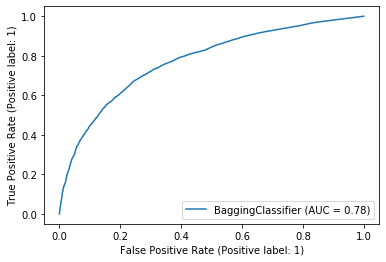

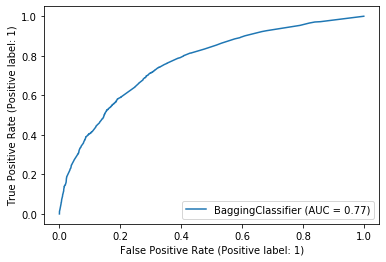

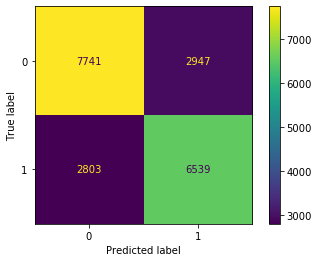

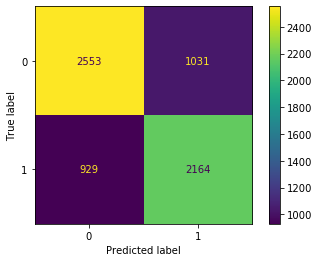

In [60]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, bagged_tree)


In [61]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train_nans, y_train)

RandomForestClassifier(max_depth=5)

ROC Scores
Train: 0.7769913368510251
Test: 0.7706443896211492


Accuracy Scores
Train: 0.7116824762855717
Test: 0.7024112625430583


F1 Scores
Train: 0.675068924773533
Test: 0.6657695542472667
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


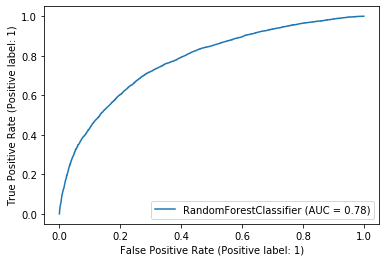

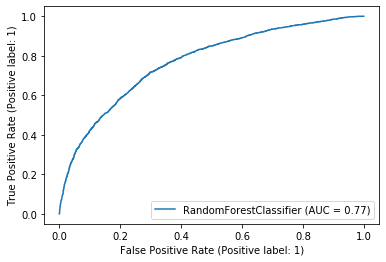

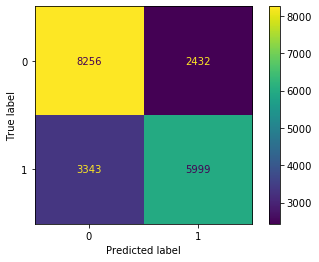

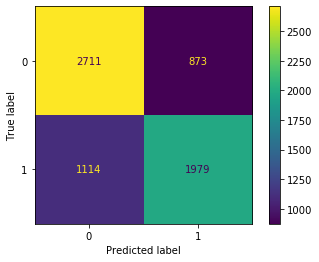

In [62]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, forest)

# no change.  Try grid search with random forest.

In [63]:
rf_param_grid = {'n_estimators': [50, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [6, 10, 14],
                 'min_samples_leaf': [3, 6, 9],
                'min_samples_split': [5, 10, 15]}
                 
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")



Training Accuracy: 71.16%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 50}


ROC Scores
Train: 0.8050660079968517
Test: 0.7740636889606716


Accuracy Scores
Train: 0.7324013979031453
Test: 0.704957316159952


F1 Scores
Train: 0.7031457687195393
Test: 0.6725398936170213
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


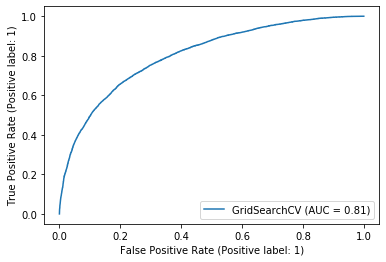

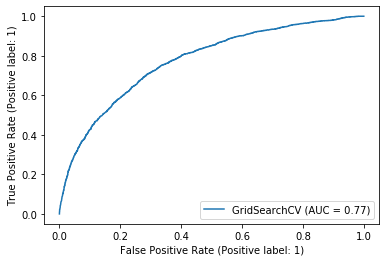

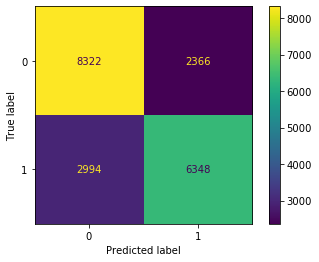

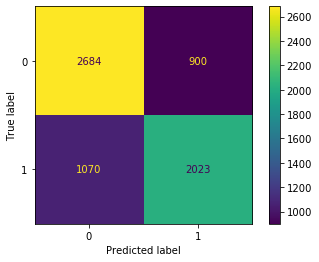

In [64]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, rf_grid_search)
# overfit

In [65]:
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train_nans, y_train)


XGBClassifier()

ROC Scores
Train: 0.7873002439645436
Test: 0.7747821170933213


Accuracy Scores
Train: 0.7182226660009985
Test: 0.7082522090759323


F1 Scores
Train: 0.6878663864616746
Test: 0.6770557029177718
Train ROC Curve
Test ROC Curve
Train Confusion Matrix:
Test Confusion Matrix:


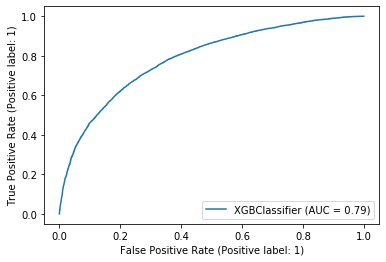

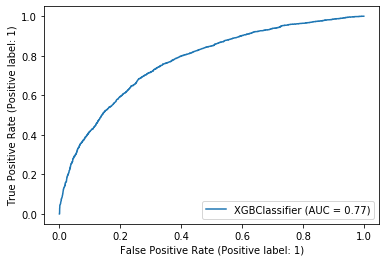

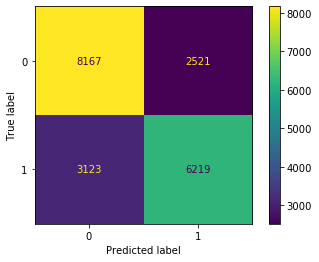

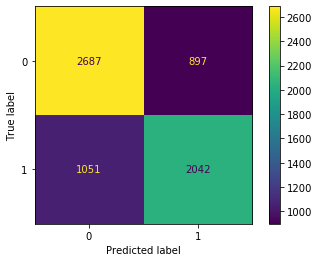

In [66]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, XGB)
# less overfit

In [67]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]}

In [68]:
grid_XGB = GridSearchCV(XGB, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB.fit(X_train_nans, y_train)


KeyboardInterrupt: 

In [ ]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB)
# overfit
# not better... try different parameters?

In [ ]:
SVM = SVC(kernel='linear')
SVM.fit(X_train_nans, y_train)

In [ ]:
y_train_pred = SVM.predict(X_train_nans)
y_test_pred = SVM.predict(X_test_nans)

#     print('ROC Scores')
#     print('Train:', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
#     print('Test:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
#     print('\n')
print('Accuracy Scores')
print('Train:', accuracy_score(y_train, y_train_pred))
print('Test:', accuracy_score(y_test, y_test_pred))
print('\n')
print('F1 Scores')
print('Train:', f1_score(y_train, y_train_pred))
print('Test:', f1_score(y_test, y_test_pred))

#     plot_roc_curve(model, X_train, y_train)
#     plot_roc_curve(model, X_test, y_test);

# worse scores for Accuracy and F1